STEP 1 — Install Libraries

In [1]:
!pip install mediapipe

STEP 2 — Webcam Capture Utility (Colab-specific)

In [5]:
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2

def take_photo():
    js_code = """
    async function capturePhoto() {
      const video = document.createElement('video');
      video.style.display = 'none';
      document.body.appendChild(video);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;

      await video.play();

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      const ctx = canvas.getContext('2d');
      ctx.drawImage(video, 0, 0);

      stream.getTracks().forEach(t => t.stop());
      video.remove();

      return canvas.toDataURL('image/jpeg', 0.9);
    }
    capturePhoto();
    """

    data_url = eval_js(js_code)
    img_bytes = b64decode(data_url.split(',')[1])
    return img_bytes


STEP 3 — Test Camera Once

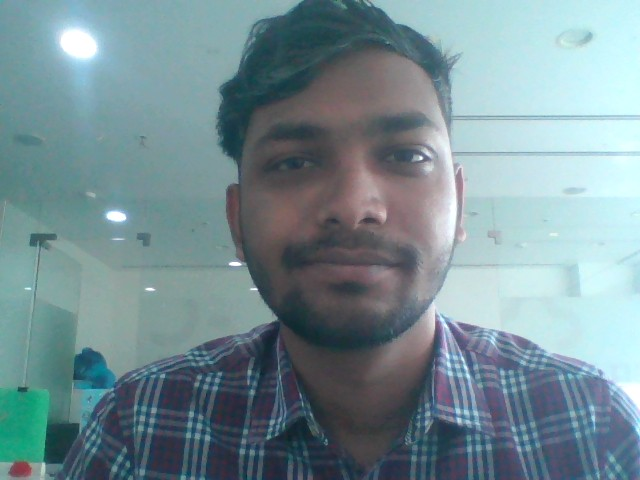

In [14]:
from PIL import Image

img_bytes = take_photo()
img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

display(Image.fromarray(img))


STEP 4 — Face Mesh Setup

In [15]:
import mediapipe as mp

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


STEP 5 — Take photo → apply face mesh → display result

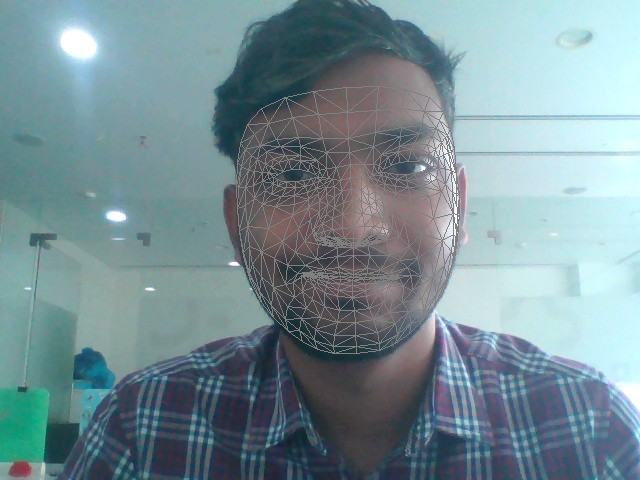

In [16]:
from PIL import Image

img_bytes = take_photo()
frame = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

results = face_mesh.process(rgb)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            rgb,
            face_landmarks,
            mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_styles.get_default_face_mesh_tesselation_style()
        )

display(Image.fromarray(rgb))
landmarks = results.multi_face_landmarks[0].landmark



STEP 5A — Convert 468 landmarks → vertices

In [17]:
import numpy as np

# Convert Mediapipe landmarks → numpy vertices
vertices = np.array([[lm.x, lm.y, lm.z] for lm in landmarks], dtype=np.float32)

# Optional: center & scale for cleaner GLB visualization
vertices -= vertices.mean(axis=0)
vertices /= np.max(np.linalg.norm(vertices, axis=1))

print("Vertices shape:", vertices.shape)

vertices = np.array([[lm.x, lm.y, lm.z] for lm in landmarks], dtype=np.float32)


Vertices shape: (478, 3)


STEP 6 — Build 3D mesh and export .glb in colab (Face Landmarks)

In [24]:
# Install trimesh if not already
!pip install trimesh -q

import trimesh
import numpy as np

# vertices from Step 5A: vertices = np.array([[lm.x, lm.y, lm.z] for lm in landmarks], dtype=np.float32)

# Flip the Y axis for proper orientation
vertices_flipped = vertices.copy()
vertices_flipped[:, 1] *= -1  # invert y

# Create point cloud
cloud = trimesh.points.PointCloud(vertices_flipped)

# Export as GLB
cloud.export("face_mesh_points_fixed.glb")
print("✅ 3D face points exported as 'face_mesh_points_fixed.glb'")


✅ 3D face points exported as 'face_mesh_points_fixed.glb'
